In [12]:
import utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

alerts_antof, _ = utils.load_data('data.json')

alerts_antof = utils.separate_coords(alerts_antof)

accident = utils.extract_event(alerts_antof, 'ACCIDENT')
jam = utils.extract_event(alerts_antof, 'JAM')
hazard = utils.extract_event(alerts_antof, 'HAZARD')

hourly_accident = utils.hourly_group(accident)
hourly_jam = utils.hourly_group(jam)
hourly_hazard = utils.hourly_group(hazard)

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

linear_model = LinearRegression()

# Join the three DataFrames on the 'hour' index
dat = hourly_accident.join(hourly_jam, lsuffix='_accident', rsuffix='_jam').join(hourly_hazard, rsuffix='_hazard')

dat

day_type,Fin de semana_accident,Semana_accident,Fin de semana_jam,Semana_jam,Fin de semana,Semana
hour,,,,,,
0,2.0,6.0,2.0,1.0,7.0,7.0
1,3.0,5.0,3.0,10.0,14.0,2.0
2,0.0,0.0,1.0,2.0,12.0,2.0
3,0.0,0.0,2.0,NaN,2.0,3.0
4,2.0,NaN,1.0,1.0,26.0,NaN
5,4.0,NaN,NaN,1.0,9.0,1.0
6,3.0,2.0,1.0,4.0,9.0,9.0
7,2.0,27.0,2.0,626.0,40.0,51.0
8,4.0,29.0,6.0,403.0,8.0,68.0


In [14]:
dat = dat[['Semana_accident', 'Semana_jam']]

# Fill missing values with 0
dat = dat.fillna(0)

# Create the feature matrix X
X = dat[['Semana_jam']].values

# Create the target vector y
y = dat['Semana_accident'].values

y = hourly_accident.Semana.fillna(0).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)

y_pred

array([ 7.91824965,  8.97035592,  5.463335  , 10.27296369,  8.87015533])

In [15]:
from sklearn.metrics import mean_squared_error, r2_score

mean_squared_error(y_test, y_pred)
r2_score(y_test, y_pred)

print(f'Coeficiente de determinación: {r2_score(y_test, y_pred)}')
print(f'Error cuadrático medio: {mean_squared_error(y_test, y_pred)}')


Coeficiente de determinación: 0.28554922137957894
Error cuadrático medio: 25.26297953201809


In [16]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(linear_model, X, y, cv=5)
print(f"R^2 scores: {scores}")

R^2 scores: [-2.60188133  0.65682932  0.21700042 -0.35969991  0.51558277]


In [17]:
import statsmodels.formula.api as smf

# Crear un DataFrame con los datos de entrenamiento
linear_model = smf.ols(data=dat, formula='Semana_accident ~ Semana_jam')
results = linear_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Semana_accident   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     54.51
Date:                Sun, 15 Sep 2024   Prob (F-statistic):           2.18e-07
Time:                        21:00:15   Log-Likelihood:                -74.793
No. Observations:                  24   AIC:                             153.6
Df Residuals:                      22   BIC:                             155.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0646      1.454      3.483      0.0

In [18]:
results.params

Intercept     5.064568
Semana_jam    0.050179
dtype: float64

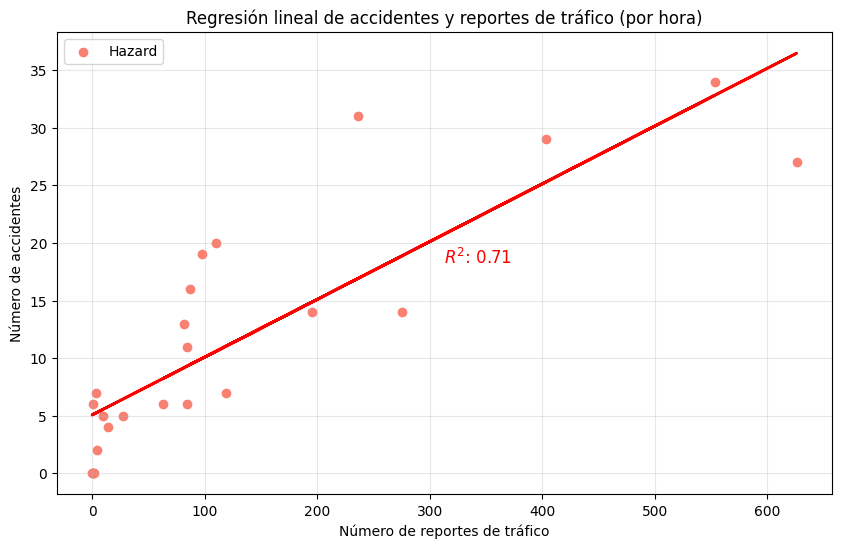

In [19]:
# Grafica la linea de regresión lineal de results y los datos originales

plt.figure(figsize=(10, 6))

# Graficar los datos originales
plt.scatter(dat['Semana_jam'], dat['Semana_accident'], color='salmon', label='Hazard')

# Graficar la línea de regresión
plt.plot(dat['Semana_jam'], results.params['Intercept'] + results.params['Semana_jam'] * dat['Semana_jam'], color='red', linewidth=2)

plt.title('Regresión lineal de accidentes y reportes de tráfico (por hora)')
plt.text(0.5, 0.5, rf'$R^2$: {results.rsquared:.2f}', transform=plt.gca().transAxes, fontsize=12,  color='red')
plt.xlabel('Número de reportes de tráfico')
plt.ylabel('Número de accidentes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [20]:
df_date = alerts_antof[['pubMillis', 'endreport', 'type']].copy()

In [21]:
df_date['pubMillis'] = df_date['pubMillis'] - 4 * 60 * 60 * 1000 # GMT-4

df_date['year'] = pd.to_datetime(df_date['pubMillis'], unit='ms').dt.year
df_date['month'] = pd.to_datetime(df_date['pubMillis'], unit='ms').dt.month
df_date['day'] = pd.to_datetime(df_date['pubMillis'], unit='ms').dt.day
df_date['hour'] = pd.to_datetime(df_date['pubMillis'], unit='ms').dt.hour

In [22]:
df_date.head()

,pubMillis,endreport,type,year,month,day,hour
0,1724403237000,1.724425e+12,HAZARD,2024,8,23,8
1,1724409478000,1.724425e+12,JAM,2024,8,23,10
2,1724411006000,1.724425e+12,JAM,2024,8,23,11
3,1724411222000,1.724425e+12,JAM,2024,8,23,11
4,1724411539000,1.724425e+12,ACCIDENT,2024,8,23,11
